# Соревнование по поиску ликов: Эталонное решение

Добро пожаловать в разбор соревнования по поиску утечек данных (data leaks)!

**Цель этого ноутбука** — наглядно показать, как можно находить и использовать различные типы ликов в данных, чтобы значительно улучшить качество модели. Мы пройдем путь от простого базового решения до продвинутого, использующего все скрытые уязвимости в датасете.

### Структура разбора:
1.  **Наивный подход (Baseline):** Сначала мы построим модель, которая не использует никаких знаний о ликах. Это будет наша отправная точка.
2.  **Работа детектива (Поиск ликов):** Затем мы начнем исследовать данные, находить аномалии и конструировать на их основе признаки. Каждый найденный лик будет подробно объяснен: в чем его суть, как его можно было заметить и почему такие ошибки возникают в реальной жизни.
3.  **Модель с ликами:** Мы обучим новую модель с использованием наших "ликовых" признаков и сравним ее качество с базовой.
4.  **Приложение (Для любознательных):** В самом конце мы покажем код, с помощью которого генерировались данные. Это позволит заглянуть "за кулисы" и увидеть, как именно каждая из утечек была заложена в датасет.

> ⚠️ **Важное замечание:** В реальных задачах и соревнованиях лики часто бывают менее очевидными и более завуалированными. Однако типы ошибок, которые к ним приводят, очень похожи на те, что мы разберем сегодня. Умение их распознавать — ценный навык для любого специалиста по данным.

## Часть 1: Подготовка и базовое решение

In [ ]:
import pandas as pd
import numpy as np
import hashlib
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

sns.set_style("whitegrid")
RANDOM_SEED = 42

# Загружаем данные
# Предполагается, что файлы лежат в папке data_kaggle/
df_train = pd.read_csv("data_kaggle/train.csv")
df_test  = pd.read_csv("data_kaggle/test.csv")
df_solution = pd.read_csv("data_kaggle/solution.csv")
df_sample_sub = pd.read_csv("data_kaggle/sample_submission.csv")

# Для удобства работы добавим колонку ID в трейн
df_train['ID'] = range(len(df_train))

In [ ]:
df_train.head()

,age,country,city,school,faculty,student_id,sociodemographics,test_score,application_id,personal_statement,accepted,ID
0,24,Россия,Санкт-Петербург,9,0,7127004,1f63c614a798186e5b5dbca02201a070,21.0,06c4288fba116e49f49d82a16184fca6,NaN,0.0,0
1,21,Казахстан,Астана,5,0,6264436,99fec0c12216abee9eec3bee2138754f,29.0,45273a0d372f7f2747afc98bdc63c31a,NaN,1.0,1
2,17,Россия,Тула,3,0,9056805,f733e24fc7ae975aab7c3e092b1ae96c,89.0,773c820049150b6854691b5e7fdcd63f,NaN,0.0,2
3,20,Украина,Киев,1,0,8857612,a2b7795cd58502654754ce03163a1685,2.0,d07f757f1b51f8b9189a84298b142794,NaN,0.0,3
4,19,Россия,Пермь,8,0,6422527,90519fbbfd457329160e9c1767cb0a86,23.0,269f19b2ef9f46af5012931bfd4acf22,NaN,0.0,4


In [ ]:
df_test.head()

,ID,age,country,city,school,faculty,student_id,sociodemographics,test_score,application_id,personal_statement
0,96000,21,Россия,Санкт-Петербург,9,0,4428545,adcb62fdc1121af780dc4138486cc7e3,63.0,700db6161a195963a89ee91a11bc6449,NaN
1,96001,22,Казахстан,Астана,5,0,4828171,05ec3873d1ced60fb3d4327bfd368e00,62.0,c818a649e468d97325813b877fb7f308,NaN
2,96002,23,Россия,Тула,3,0,6305415,1533b17f2c49fec036550ee67955b0a6,17.0,0cc80bc0aa8531794601980c4c2f0fb7,NaN
3,96003,17,Украина,Киев,1,0,5175385,f1eef626c29a481a5527d242ae5516a8,25.0,ed05d43a670eea5a75662cc82d3a4b7d,NaN
4,96004,24,Россия,Пермь,8,0,1809466,67086df93882a3958b6163a60d0bd6b5,64.0,7b3e7852822d85f1de686caeb0c6307d,NaN


### 1.1 Модель "без ликов" (Baseline)

Начнем с простого подхода. Мы будем использовать только исходные признаки, не пытаясь найти в них скрытые закономерности. Это даст нам базовый результат (baseline), от которого мы будем отталкиваться.

Единственная предобработка — заполним пропуски в текстовой колонке `personal_statement`, чтобы модель могла с ней работать.

In [ ]:
FEATURES_BASE = [
    'age', 'country', 'city', 'school', 'faculty', 'student_id',
    'sociodemographics', 'test_score', 'application_id', 'personal_statement'
]
TARGET = 'accepted'

# Создаем копии, чтобы не изменять оригинальные датафреймы
X_train_base = df_train[FEATURES_BASE].copy()
y_train_base = df_train[TARGET].copy()
X_test_base  = df_test[FEATURES_BASE].copy()

# Заполняем пропуски в personal_statement
X_train_base['personal_statement'] = X_train_base['personal_statement'].fillna('').astype(str)
X_test_base['personal_statement']  = X_test_base['personal_statement'].fillna('').astype(str)

# Определяем категориальные признаки для CatBoost
cat_features_base_indices = np.where(X_train_base.dtypes != np.number)[0]

# Обучаем базовую модель
model_base = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    random_seed=RANDOM_SEED,
    verbose=False
)
model_base.fit(X_train_base, y_train_base, cat_features=cat_features_base_indices)

# Делаем предсказание
y_pred_base = model_base.predict_proba(X_test_base)[:,1]

# Считаем ROC AUC на полном тестовом сете
df_pred_base = df_test[['ID']].copy()
df_pred_base['accepted'] = y_pred_base
df_merge_base = pd.merge(df_solution, df_pred_base, on='ID', suffixes=('_true','_pred'))
auc_base = roc_auc_score(df_merge_base['accepted_true'], df_merge_base['accepted_pred'])

print(f"ROC AUC базовой модели: {auc_base:.4f}")

ROC AUC базовой модели: 0.5808


Как видим, результат едва отличается от случайного (0.5). Это говорит о том, что в "сырых" данных практически нет полезного сигнала. Пора приступать к поиску ликов.

## Часть 2: Поиск и эксплуатация ликов

Теперь начинается самое интересное. Мы будем действовать как дата-детективы, исследуя данные на предмет аномалий и скрытых закономерностей. Каждый найденный лик мы превратим в новый, мощный признак.

Для удобства создадим копии датафреймов, в которые будем добавлять новые признаки.

In [ ]:
df_train_lk = df_train.copy()
df_test_lk = df_test.copy()

# Заполняем пропуски в personal_statement, чтобы не делать это для каждого лика
df_train_lk['personal_statement'] = df_train_lk['personal_statement'].fillna('').astype(str)
df_test_lk['personal_statement']  = df_test_lk['personal_statement'].fillna('').astype(str)

### Лик №1: Неслучайный порядок строк (Эффект "пилы")

**Суть лика:** Данные в датасете не были перемешаны случайным образом. Заявки сгруппированы по факультетам (`faculty`), и внутри каждой группы они отсортированы по некой скрытой логике, которая сильно коррелирует с целевой переменной. В начале списка каждого факультета находятся заявки с более высокой вероятностью зачисления, а в конце — с более низкой, с некоторыми выбросами.

**Как найти:** Простой визуальный анализ мог бы выявить эту закономерность. Если построить график скользящего среднего для `accepted` по мере прохождения по датасету, можно было бы увидеть повторяющийся пилообразный паттерн. Дальнейшее исследование показало бы, что эти "зубцы пилы" идеально совпадают со сменой факультета. Это означает, что порядковый номер заявки внутри факультета — сильный признак.

**Почему возникает:** Классическая ошибка организаторов — **забыли перемешать данные** (зашафлить) перед публикацией. Такое встречается и в реальных задачах, например, когда данные выгружаются из базы, где они уже упорядочены по дате, ID или другому критерию, который коррелирует с таргетом.

**Решение:** Создадим признак `rank_reconstructed`. Он будет представлять собой порядковый номер заявки внутри каждой группы по факультету, нормированный от 0 до 1. Это позволит модели уловить тренд. Важно заметить, что тестовый датасет состоит из двух частей (public и private), и ранг нужно считать для каждой части отдельно.

In [ ]:
# Восстанавливаем ранг для трейна
df_train_lk['rank_reconstructed'] = df_train_lk.groupby('faculty').cumcount() / df_train_lk.groupby('faculty')['ID'].transform('count')

# Восстанавливаем ранг для теста, разделяя его на две части (public/private)
half_test = len(df_test_lk) // 2
df_test_lk.loc[:half_test-1, 'rank_reconstructed'] = df_test_lk.iloc[:half_test].groupby('faculty').cumcount() / df_test_lk.iloc[:half_test].groupby('faculty')['ID'].transform('count')
df_test_lk.loc[half_test:, 'rank_reconstructed'] = df_test_lk.iloc[half_test:].groupby('faculty').cumcount() / df_test_lk.iloc[half_test:].groupby('faculty')['ID'].transform('count')

print("Признак 'rank_reconstructed' добавлен.")
df_train_lk[['ID', 'faculty', 'rank_reconstructed']].head()

Признак 'rank_reconstructed' добавлен.


,ID,faculty,rank_reconstructed
0,0,0,0.000000
1,1,0,0.000063
2,2,0,0.000125
3,3,0,0.000188
4,4,0,0.000251


### Те самые пилы для train и test

<Axes: >

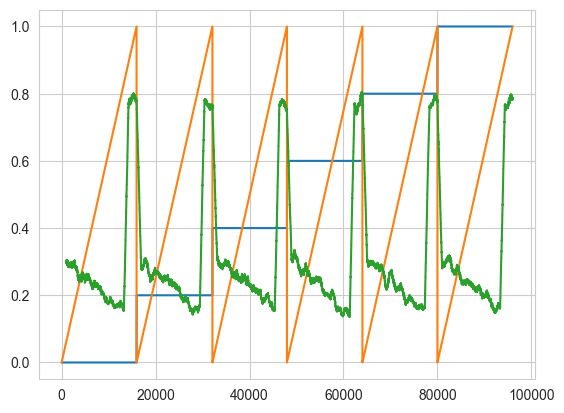

In [ ]:
(df_train_lk.faculty / 5).plot()
df_train_lk.rank_reconstructed.plot()
df_train_lk.reset_index().rolling(1000).accepted.mean().plot()

<Axes: >

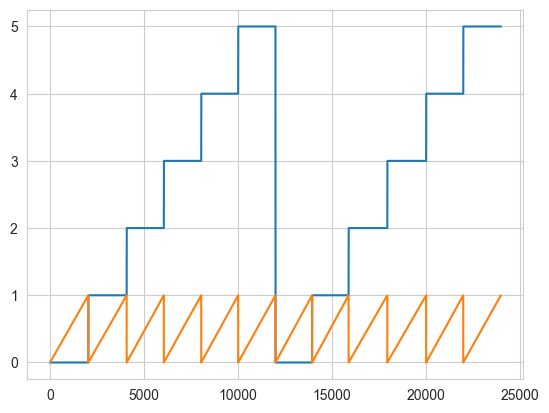

In [ ]:
df_test_lk.faculty.plot()
df_test_lk.rank_reconstructed.plot()

### Лик №2: Разный тип данных в `test_score`

**Суть лика:** В колонке `test_score` большинство значений — целые числа, но некоторые являются числами с плавающей точкой (float). Оказывается, наличие дробной части сильно коррелирует с целевой переменной.

**Как найти:** Методом "пристального взгляда" на данные. Просматривая значения `test_score`, можно заметить, что некоторые из них имеют вид `XX.XX`. Проверив, как это связано с таргетом, мы бы увидели, что почти все заявки с `float` значением в `test_score` были приняты (`accepted` = 1).

**Почему возникает:** Такая ошибка часто появляется, когда данные собираются из разных источников или разными скриптами. Например, один процесс сохраняет баллы как целые числа, а другой (возможно, для принятых абитуриентов) — как дробные. Организаторы забыли привести данные к единому формату.

**Решение:** Создадим бинарный признак `was_float`, который будет равен 1, если в `test_score` есть точка, и 0 в противном случае.

**Пример исследования:** Взяв случайную выборку, можно несложно заметить выбивающееся из колеи float значение test_score (14 строчка), поскольку мы ищем лики - не будет лишним проверить зависимость таргета от типа переменной test_score, в целом в любых соревнованиях важно глазами оценивать данные, даже таблички.

In [ ]:
df_train_lk.sample(30, random_state=42).reset_index(drop=True)

,age,country,city,school,faculty,student_id,sociodemographics,test_score,application_id,personal_statement,accepted,ID,rank_reconstructed
0,23,Беларусь,Гродно,8,5,9528950,1c49df9618d0ff1037c90c1f4f6afc0e,10.00,cc4afbb443c83bb377d1733af7454f60,,1.0,83250,0.202677
1,18,Беларусь,Витебск,19,4,2355040,5e8668a555b3c4cf31b5e59ccbf7dc4e,53.00,178da5c3faaabf8647eda8b227dfc080,,0.0,71978,0.497183
2,19,Россия,Казань,19,2,9468379,cea086b90094612fc3072f9037bf6307,93.00,13028fe462bac5ef71c2082e12396001,,1.0,47489,0.970052
3,20,Россия,Екатеринбург,2,5,1236636,7e41c8c2646e8ec86ff9feb453b65b7e,8.00,f7e377af674f9d9403b8207553169252,,1.0,94910,0.931837
4,18,Украина,Запорожье,9,1,1849543,24b8a0d628218b1c58a654e98303dc3d,60.00,95ca4d584fa7a6f1e4159f0717135829,,0.0,18844,0.179009
5,25,Беларусь,Гомель,2,4,5865432,1ce8f0f5d51b4aff1ee813b131ee7c88,89.44,b9671c379d9e7915d9001d1f0096d21f,,1.0,64622,0.036627
6,20,Беларусь,Гродно,1,0,7945571,999de5aeac0e15044bd2b893f331dd61,5.00,36220c7f12264ba77d17f32f9c2bce4f,,0.0,6662,0.417602
7,17,Украина,Одесса,8,3,8462780,bfbca9e6c1e7d0b3e670af72336b6e60,69.00,14011d1cf7dd7306893a8e264d4dc946,,1.0,63817,0.986312
8,25,Украина,Киев,13,4,2172220,e95acb9dd96d64d501a2aabc1c77f2be,71.00,d0e588880ef5a75ef26f6aa3917a756e,,0.0,65648,0.100864
9,25,Казахстан,Астана,9,0,4818008,10e4180bd42c7cb8a9b203d61b32fd4c,69.00,4dc692d4be3985e9006f7321adef1ede,,1.0,3022,0.189431


**Это можно было увидеть и в сырых данных**. Обратите внимание на test_score `78.95` во второй строчке вывода ячейки ниже. Увидеть такое в данные - странно, ведь если бы колонка была float, то во всех строчках были бы значения с точкой на конце, но тут записаны как целые, так и дробные значения. Важный урок здесь в том, что всегда следует смотреть на изначальные сырые данные, а не то представление, которое вам дает pandas или любая другая библиотека, которая считывает данные. Этот вывод применим и к картинкам, и звуковым файлам, и текстовым, и так далее. В них важным может оказаться не только разрешение картинки или ее формат, но и метаданные, такие как дата модификации файла, права доступа к файлу, или программа которая его последний раз редактировала.

In [ ]:
!head -1 data_kaggle/train.csv
!head -165 data_kaggle/train.csv | tail -5

age,country,city,school,faculty,student_id,sociodemographics,test_score,application_id,personal_statement,accepted
20,Беларусь,Витебск,15,0,2023220,aa3299835464e148e6a1a42d2add53b7,78.95,9a1bd4cc3c897fc26a034d880059520e,,1.0
25,Украина,Запорожье,7,0,1312736,e95acb9dd96d64d501a2aabc1c77f2be,27,b511ca3eae7b0aa119255c7d8d3dfe53,,0.0
25,Украина,Кривой Рог,6,0,4838783,e95acb9dd96d64d501a2aabc1c77f2be,27,f382ba2f96e888b93efe76f2ddf0184e,,0.0
17,Россия,Тольятти,17,0,7566343,a2e56b1228f7a0ed258b802f5d7c783d,91,714ea40069bbe55880390489c4186c04,,1.0
23,Беларусь,Минск,8,0,1318913,9dd02374faf34265f9bf0f6410a3cbcd,5,f61fdb98ec60381597a783dd5b76340e,,1.0


In [ ]:
def is_float_str(s):
    # Проверяем, является ли строка представлением float
    return round(s) == s

df_train_lk['was_float'] = df_train_lk['test_score'].apply(is_float_str).astype(int)
df_test_lk['was_float']  = df_test_lk['test_score'].apply(is_float_str).astype(int)

print("Признак 'was_float' добавлен.")
# Посмотрим, насколько сильна корреляция
print("Среднее значение таргета для каждой группы:")
print(df_train_lk.groupby('was_float')['accepted'].mean())

Признак 'was_float' добавлен.
Среднее значение таргета для каждой группы:
was_float
0    0.837748
1    0.301431
Name: accepted, dtype: float64


### Лик №3: Неслучайный `student_id`

**Суть лика:** `student_id` не является случайным набором цифр. Предпоследняя цифра (разряд десятков) в ID коррелирует с таргетом.

**Как найти:** ID-шники никогда не следует игнорировать. Часто в них зашита полезная информация (дата регистрации, регион и т.д.). Простейший способ анализа — извлечь из ID различные числовые признаки (например, последнюю цифру, первые две, остаток от деления) и проверить их корреляцию с таргетом. В данном случае, взяв остаток от деления на 100 и посмотрев на разряд десятков, можно было заметить, что если он четный (0, 2, 4), то таргет чаще равен 1, а если нечетный (1, 3, 5) — то 0.

**Почему возникает:** Это типичная проблема, когда ID генерируются не полностью случайно, а по какому-то алгоритму, который может быть связан с другими процессами. Например, ID могут выдаваться из разных пулов для разных категорий пользователей. Зачастую такие id могут содержать дату регистрации аккаунта пользователя, его номер телефона и другое.

**Решение:** Создадим признак `id_leak`, который будет принимать значение 1 для цифр окончания ID соответствующих accepted=1, 0 для соответствующих accepted=0 и -1 для всех остальных случаев.

In [ ]:
def extract_id_leak(x):
    last2 = x % 100
    tens = last2 // 10
    if tens in [0, 2, 4]:
        return 1  # Вероятно, accepted = 1
    elif tens in [1, 3, 5]:
        return 0  # Вероятно, accepted = 0
    else:
        return -1 # Нейтральное значение

df_train_lk['id_leak'] = df_train_lk['student_id'].apply(extract_id_leak)
df_test_lk['id_leak']  = df_test_lk['student_id'].apply(extract_id_leak)

print("Признак 'id_leak' добавлен.")
print("\nПроверка корреляции с таргетом:")
print(df_train_lk.groupby('id_leak')['accepted'].mean())

Признак 'id_leak' добавлен.

Проверка корреляции с таргетом:
id_leak
-1    0.319465
 0    0.239309
 1    0.448196
Name: accepted, dtype: float64


### Лик №4: Расшифровка хэша `sociodemographics`

**Суть лика:** Колонка `sociodemographics` — это MD5-хэш, сгенерированный без "соли". Он был создан путем конкатенации пола, возраста и страны абитуриента (`gender` + `age` + `country`). Поскольку пол был скрыт, его можно восстановить, перебрав всего два варианта ('M' и 'F').

**Как найти:** Во-первых, значения в колонке похожи на 32-значный шестнадцатеричный хэш, что наводит на мысль об MD5. Во-вторых, если сгруппировать данные по `age` и `country`, можно заметить, что для каждой такой группы существует всего два уникальных значения `sociodemographics`. Это явный намек на то, что в хэш закодирован какой-то бинарный признак, скорее всего, пол.

**Почему возникает:** Организаторы хотели анонимизировать данные (можно предположить, что чтобы убрать bias модели по полу), но использовали **хэширование без соли**. Это делает хэш уязвимым для атак перебором (brute-force) или с использованием "радужных таблиц" (rainbow tables), особенно когда исходные данные (возраст, страна) известны.

**Решение:** Напишем функцию, которая для каждой строки пробует сгенерировать хэш для 'M' и 'F' и сравнивает с имеющимся. Так мы восстановим исходный признак `gender`.

**Пример исследования:** Сгруппируем датасет по age и country и посмотрим уникальные значения sociodemographics в каждой группе, видим, что везде количество - 2, значит можно попытаться как-то декодировать данные sociodemographics, в нашем случае восстановить gender. Далеко не всегда такие группировки могут дать значительный результат, а поскольку комбинаций для группировок зачастую очень много, то слишком много времени этому уделять не стоит. Тем не менее, в случае успеха вас могут ждать ценные признаки, которые не получилось извлечь у других участников соревнования.

In [ ]:
grs = df_train_lk.groupby(['age', 'country'], as_index=False).agg({'sociodemographics': set})
grs['length'] = grs['sociodemographics'].apply(len)
print(grs['length'].unique())
grs.head()

[2]


,age,country,sociodemographics,length
0,17,Беларусь,"{e7d4f790b86d0b8f1e80a3f181e7add2, c619abe4f81...",2
1,17,Казахстан,"{56b4da4b9f916a54be39f26757c8ce14, 37f60294353...",2
2,17,Россия,"{f733e24fc7ae975aab7c3e092b1ae96c, a2e56b1228f...",2
3,17,Украина,"{bfbca9e6c1e7d0b3e670af72336b6e60, f1eef626c29...",2
4,18,Беларусь,"{b0f371fa4e704cac2af1c0bbdfa11940, 5e8668a555b...",2


**Дополнение:** Функция ниже написана уже с полным пониманием способа декодирования, но зачастую чтобы найти правильный способ рассчета хэша из имеющихся признаков, на это может уйти много времени: например, между age, gender и country может стоять разделительный дефис, порядок переменных может быть другой и тд.


In [ ]:
def recover_gender(df):
    recovered_genders = []
    for idx, row in df.iterrows():
        a, c, target_md5 = row['age'], row['country'], row['sociodemographics']

        # Проверяем гипотезу для 'M'
        if hashlib.md5(f"M{a}{c}".encode('utf-8')).hexdigest() == target_md5:
            recovered_genders.append('M')
        # Проверяем гипотезу для 'F'
        elif hashlib.md5(f"F{a}{c}".encode('utf-8')).hexdigest() == target_md5:
            recovered_genders.append('F')
        else:
            recovered_genders.append(None) # Если не удалось восстановить

    return recovered_genders

df_train_lk['recovered_gender'] = recover_gender(df_train_lk)
df_test_lk['recovered_gender']  = recover_gender(df_test_lk)

print("Признак 'recovered_gender' добавлен.")
print("\nПроверка корреляции с таргетом:")
print(df_train_lk.groupby('recovered_gender')['accepted'].mean())

Признак 'recovered_gender' добавлен.

Проверка корреляции с таргетом:
recovered_gender
F    0.380465
M    0.259191
Name: accepted, dtype: float64


### Лик №5: Дубликаты студентов

**Суть лика:** В данных присутствуют дубликаты по `student_id`. Вероятно, это означает, что один и тот же студент подавал несколько заявок (например, на разные факультеты). При анализе этих групп в трейне выясняется, что если у студента более одной заявки, то одна из них всегда принята, а другая — нет.

**Как найти:** Посчитать количество вхождений каждого `student_id`. `df_train['student_id'].value_counts()`. Увидев, что есть ID, которые встречаются более одного раза, можно было отфильтровать датасет по этим ID и посмотреть на их таргеты. Это бы сразу выявило закономерность `0/1`.

**Почему возникает:** Ошибка при формировании датасета - организаторы оставили возможность связать строки друг с другом, хотя, возможно, и не хотели этого. По сути, это нарушает предположение о независимости наблюдений, а когда оно нарушается, нам как раз и следует добавить информацию о зависимых строчках в качестве фичи или использовать ее другим образом.

**Решение:** Мы не будем реализовывать этот лик в модели напрямую, так как он требует более сложной логики (пост-обработки предсказаний). В целом, стоит найти группы дубликатов в тесте, предсказать вероятности для каждой заявки, а затем для каждой группы принудительно выставить `1` для заявки с наибольшей вероятностью и `0` для остальных. В качестве более простого подхода и для демонстрации мы добавим фичу "количество строк в датасете для этого student_id" - но постобработка прогнозов должна быть куда более эффективной.

**Пример исследования:** Сгруппируем по student_id наш датасет и посмотрим сколько заявок приходится на каждого студента, чаще всего 1 заявка, а далее по возрастанию количества заявок убывает количество таких студентов. Ниже можно заметить что у каждого "интересного" студента (количество заявок = 2) одна принята, а другая нет

In [ ]:
grs = df_train_lk.groupby('student_id', as_index=False).agg({'application_id': 'count'})
counts = pd.concat([df_train_lk, df_test_lk]).groupby('student_id').application_id.count()
df_train_lk['n_records'] = df_train_lk['student_id'].map(counts)
df_test_lk['n_records'] = df_test_lk['student_id'].map(counts)

interesting_ids = grs[grs['application_id'] == 2]['student_id'].tolist()
print(grs['application_id'].unique())
grs['application_id'].value_counts()

[1 2 3 4]


application_id
1    63629
2    16053
3       75
4       10
Name: count, dtype: int64

In [ ]:
df_train_lk[df_train_lk['student_id'].isin(interesting_ids)].sort_values(by='student_id').head(10)

,age,country,city,school,faculty,student_id,sociodemographics,test_score,application_id,personal_statement,accepted,ID,rank_reconstructed,was_float,id_leak,recovered_gender,n_records,salt_flag
63773,17,Россия,Уфа,20,3,1000643,a2e56b1228f7a0ed258b802f5d7c783d,70.0,2ccf4595a1cb0c5ad44b55ec952ead1d,,1.0,63773,0.983575,1,1,F,2,1
7943,17,Россия,Уфа,20,0,1000643,a2e56b1228f7a0ed258b802f5d7c783d,70.0,2ccf4595a1cb0c5ad44b55ec952ead1d,,0.0,7943,0.497900,1,1,F,2,1
54528,24,Беларусь,Витебск,13,3,1001203,639879d0115e8075d21a7619d63c41ee,4.0,9349b539452be4d10d652f4bad47f371,,1.0,54528,0.408387,1,1,M,2,0
47664,24,Беларусь,Витебск,13,2,1001203,639879d0115e8075d21a7619d63c41ee,4.0,9349b539452be4d10d652f4bad47f371,,0.0,47664,0.981086,1,1,M,2,0
41438,20,Беларусь,Витебск,11,2,1001289,999de5aeac0e15044bd2b893f331dd61,13.0,8d8e32d2861c185e4ccf83cf70a80a63,,0.0,41438,0.588551,1,-1,M,2,0
30698,20,Беларусь,Витебск,11,1,1001289,999de5aeac0e15044bd2b893f331dd61,13.0,8d8e32d2861c185e4ccf83cf70a80a63,,1.0,30698,0.913003,1,-1,M,2,0
61441,18,Россия,Ижевск,7,3,1001395,9f2e1b173d3fc6d305927e37ee74ac91,28.0,ee1fdafc80bc03e86373fbed42a84789,,1.0,61441,0.838487,1,-1,M,2,1
21737,18,Россия,Ижевск,7,1,1001395,9f2e1b173d3fc6d305927e37ee74ac91,28.0,ee1fdafc80bc03e86373fbed42a84789,,0.0,21737,0.358142,1,-1,M,2,1
58515,23,Беларусь,Гродно,14,3,1001898,9dd02374faf34265f9bf0f6410a3cbcd,43.0,cb36fb1f1de657cdca9d99b763e682bf,,1.0,58515,0.656442,1,-1,F,2,1
30903,23,Беларусь,Гродно,14,1,1001898,9dd02374faf34265f9bf0f6410a3cbcd,43.0,cb36fb1f1de657cdca9d99b763e682bf,,0.0,30903,0.925697,1,-1,F,2,1


### Лик №6: Хэш с простой солью в `application_id`

**Суть лика:** Колонка `application_id` также является MD5-хэшем. На этот раз организаторы использовали "соль", но она была слишком простой и предсказуемой: либо `"salt1"`, либо `"salt2"`. Выбор соли коррелировал с целевой переменной.

**Как найти:** Как и с прошлым хэшем, внешний вид колонки намекает на хэширование. Логично предположить, что уникальный `application_id` как-то связан с уникальным `student_id`. Простая конкатенация `student_id` с разными строками (солями) и последующее хэширование позволило бы быстро найти правильные соли: `salt1` и `salt2`.

**Почему возникает:** Использование слабой, неслучайной и предсказуемой соли — это распространенная ошибка в безопасности, которая может просочиться и в задачи анализа данных. Если соль не является случайной для каждой записи, а выбирается по какому-то правилу, это правило может стать источником утечки.

**Решение:** Создадим признак `salt_flag`, который будет равен 1, если использовалась `salt1`, 0 — если `salt2`, и -1 — если ни одна не подошла.

**Пример исследования:** Заметим что для каждого student_id зачастую есть всего 1 application_id, и только в малом количестве случаев их 2. Как раз такое может натолкнуть на то, что составители данных использовали для кодировки какую-нибудь странную технику - в нашем случае простую соль, однако подчеркнем, что даже если получилось такое заметить, найти соль которая скорее всего никак по смыслу не связана с данными - задача почти невозможная, и даже в этой сореве не зная про `salt1` и `salt2` декодировать точно будет почти невозможно и даже если получится, далеко не факт что эта соль будет помогать при предсказании. Тем не менее, такие странные лики тоже бывают:)

In [ ]:
grs = df_train_lk.groupby('student_id', as_index=False).agg({'application_id': set})
grs['length'] = grs['application_id'].apply(len)
print(grs['length'].unique())
grs['length'].value_counts()

[1 2]


length
1    79649
2      118
Name: count, dtype: int64

In [ ]:
def guess_salt_flag(df):
    salt_flags = []
    for idx, row in df.iterrows():
        sid = str(row['student_id'])
        hsh = row['application_id']

        s1 = hashlib.md5((sid + 'salt1').encode('utf-8')).hexdigest()
        s2 = hashlib.md5((sid + 'salt2').encode('utf-8')).hexdigest()

        if s1 == hsh:
            salt_flags.append(1)
        elif s2 == hsh:
            salt_flags.append(0)
        else:
            salt_flags.append(-1)
    return salt_flags

df_train_lk['salt_flag'] = guess_salt_flag(df_train_lk)
df_test_lk['salt_flag']  = guess_salt_flag(df_test_lk)

print("Признак 'salt_flag' добавлен.")
print("\nПроверка корреляции с таргетом:")
print(df_train_lk.groupby('salt_flag')['accepted'].mean())

Признак 'salt_flag' добавлен.

Проверка корреляции с таргетом:
salt_flag
0    0.254499
1    0.372272
Name: accepted, dtype: float64


## Часть 3: Модель с использованием ликов

Теперь, когда мы создали все наши "ликовые" признаки, давайте обучим новую модель и посмотрим, насколько улучшится качество.

In [ ]:
# Собираем все признаки вместе
FEATURES_LEAK = [
    'age', 'country', 'city', 'school', 'faculty', 'student_id',
    'sociodemographics', 'test_score', 'application_id', 'personal_statement',
    # Новые признаки из ликов
    'rank_reconstructed', 'was_float', 'id_leak', 'recovered_gender', 'salt_flag', 'n_records'
]

X_train_lk = df_train_lk[FEATURES_LEAK].copy()
y_train_lk = df_train_lk[TARGET].copy()
X_test_lk  = df_test_lk[FEATURES_LEAK].copy()

# Определяем категориальные признаки для CatBoost
cat_features_leak_indices = np.where(X_train_lk.dtypes != np.number)[0]

# Обучаем модель с ликами
model_leak = CatBoostClassifier(
    iterations=100,
    learning_rate=0.1,
    random_seed=RANDOM_SEED,
    verbose=False
)
model_leak.fit(X_train_lk, y_train_lk, cat_features=cat_features_leak_indices)

# Делаем предсказание
y_pred_leak = model_leak.predict_proba(X_test_lk)[:,1]

# Считаем ROC AUC
df_pred_leak = df_test[['ID']].copy()
df_pred_leak['accepted'] = y_pred_leak
df_merge_leak = pd.merge(df_solution, df_pred_leak, on='ID', suffixes=('_true','_pred'))
auc_leak = roc_auc_score(df_merge_leak['accepted_true'], df_merge_leak['accepted_pred'])

print(f"ROC AUC модели с ликами: {auc_leak:.4f}")

ROC AUC модели с ликами: 0.8578


## Часть 4: Сравнение результатов и выводы

In [ ]:
print(f"ROC AUC без ликов = {auc_base:.4f}")
print(f"ROC AUC с ликами  = {auc_leak:.4f}")
print("-----------------------------------")

# Посчитаем отдельно для Public и Private частей
for usage_type in ['Public', 'Private']:
    mb_idx = df_merge_base['Usage'] == usage_type
    ml_idx = df_merge_leak['Usage'] == usage_type

    auc_b = roc_auc_score(df_merge_base.loc[mb_idx, 'accepted_true'], df_merge_base.loc[mb_idx, 'accepted_pred'])
    auc_l = roc_auc_score(df_merge_leak.loc[ml_idx, 'accepted_true'], df_merge_leak.loc[ml_idx, 'accepted_pred'])

    print(f"{usage_type} LB => AUC base={auc_b:.4f} | leak={auc_l:.4f}")

ROC AUC без ликов = 0.5808
ROC AUC с ликами  = 0.8578
-----------------------------------
Public LB => AUC base=0.5808 | leak=0.8599
Private LB => AUC base=0.5808 | leak=0.8557


### Важность признаков

Давайте посмотрим, какие признаки модели посчитали самыми важными. Это наглядно продемонстрирует силу найденных нами ликов.

In [ ]:
print("Важность признаков в базовой модели:")
base_importance = pd.Series(model_base.feature_importances_, index=X_train_base.columns).sort_values(ascending=False)
print(base_importance)

print("\nВажность признаков в модели с ликами:")
leak_importance = pd.Series(model_leak.feature_importances_, index=X_train_lk.columns).sort_values(ascending=False)
print(leak_importance)

Важность признаков в базовой модели:
student_id            74.175651
application_id        19.790267
sociodemographics      5.203643
city                   0.291733
country                0.227037
test_score             0.165202
school                 0.068707
age                    0.044027
faculty                0.033733
personal_statement     0.000000
dtype: float64

Важность признаков в модели с ликами:
rank_reconstructed    40.659503
student_id            25.023809
was_float             12.393511
id_leak                8.032908
salt_flag              5.035227
recovered_gender       2.942887
sociodemographics      1.832583
n_records              1.685834
application_id         1.605556
city                   0.455884
country                0.240585
school                 0.034696
test_score             0.020998
age                    0.018126
faculty                0.017894
personal_statement     0.000000
dtype: float64


### Выводы

1. **Качество модели взлетело с 0.58 до 0.85!** Это классический пример того, как feature engineering, основанный на поиске утечек, может координально изменить результат.
2. **Важность признаков изменилась.** В базовой модели CatBoost пытался извлечь хоть какую-то информацию из ID и хэшей, поэтому у них высокая важность. В модели с ликами наши новые, явно созданные признаки (`rank_reconstructed`, `was_float`, `id_leak` и др.) стали доминирующими, так как они несут прямой и чистый сигнал о таргете.
3. **Лики бывают разными.** Мы увидели утечки, связанные с:
    - Порядком данных (сортировка).
    - Форматом данных (int vs float).
    - Неслучайной генерацией ID.
    - Небезопасным хэшированием (без соли и со слабой солью).
    - Наличием дубликатов с предсказуемым таргетом.

Надеюсь, этот разбор был полезен и показал, насколько важно внимательно исследовать данные перед построением модели. Удачи на следующих соревнованиях!

---

## Приложение: Код для генерации данных

Здесь представлен код, который использовался для создания датасета с описанными выше ликами. Это поможет понять, как именно были заложены уязвимости. *Этот код не является частью решения, а приводится для общего развития.*

In [ ]:
import pandas as pd
import numpy as np
import random
import hashlib
import os

###############################################################################
# ПАРАМЕТРЫ
###############################################################################
N_TRAIN = 80000
N_TEST = 20000
FACULTY_COUNT = 6
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

USE_TEXT_API = False  # заглушка для генерации текстов

###############################################################################
# 1. ГЕНЕРАЦИЯ ДАННЫХ (со скрытым faculty_rank)
###############################################################################

def generate_synthetic_data(n_samples, is_train=True):
    """
    Генерация датасета с ликами. 'faculty_rank' будет убран перед итоговым CSV,
    чтобы участники его не видели.
    """

    # gender (не публикуем, но используем при генерации)
    gender = np.random.choice(['M','F'], size=n_samples)

    # age, country, city, school
    age = np.random.randint(17, 26, size=n_samples)
    import random

    def generate_triples(country_city_map, school_range, count):
        random.seed(42)  # Фиксируем случайность
        triples = []
        for _ in range(count):
            country = random.choice(list(country_city_map.keys()))
            city = random.choice(country_city_map[country])
            school_number = random.randint(school_range[0], school_range[1])
            triples.append((country, city, school_number))
        return triples

    # Пример использования
    country_city_map = {
        "Россия": [
            "Москва", "Санкт-Петербург", "Новосибирск", "Екатеринбург", "Нижний Новгород",
            "Казань", "Челябинск", "Омск", "Самара", "Ростов-на-Дону", "Уфа", "Красноярск",
            "Воронеж", "Пермь", "Волгоград", "Краснодар", "Саратов", "Тюмень", "Тольятти",
            "Ижевск", "Барнаул", "Ульяновск", "Владивосток", "Ярославль", "Иркутск", "Томск",
            "Кемерово", "Оренбург", "Новокузнецк", "Рязань", "Набережные Челны", "Астрахань",
            "Пенза", "Липецк", "Тула", "Киров", "Чебоксары", "Калининград", "Курск", "Улан-Удэ"
        ],
        "Казахстан": ["Алматы", "Астана", "Шымкент", "Караганда", "Актау", "Актобе", "Павлодар"],
        "Беларусь": ["Минск", "Гомель", "Могилёв", "Витебск", "Гродно", "Брест"],
        "Украина": ["Киев", "Харьков", "Одесса", "Днепр", "Львов", "Запорожье", "Кривой Рог"]
    }
    school_range = (1, 20)  # Диапазон номеров школ

    triples = generate_triples(country_city_map, school_range, n_samples)

    # Векторы стран, городов и школ
    country = np.array([triple[0] for triple in triples])
    city = np.array([triple[1] for triple in triples])
    school = np.array([triple[2] for triple in triples], dtype=int)

    # faculty (0..FACULTY_COUNT-1)
    faculty = np.array(sorted(np.random.randint(0, FACULTY_COUNT, size=n_samples)))

    # Для "пилы" создадим rank (уберём позже)
    df_temp = pd.DataFrame({'idx': range(n_samples), 'faculty': faculty})
    df_temp['faculty_rank'] = df_temp.groupby('faculty')['idx'].rank(method='first', pct=True)

    # Формируем base_score (уменьшенные коэффициенты!):
    base_score = (gender=='F')*0.2 + np.isin(country,['Россия'])*0.1
    age_norm = (age - 18)/(40 - 18)  # [0..1]
    base_score += age_norm*0.2
    base_score += (1 - df_temp['faculty_rank'].values) * 0.2
    base_score = (base_score - base_score.min()) / (base_score.max() - base_score.min())
    # Итог: base_score ~ [0..0.2]
    # Сожмём через сигмоиду (1.0*(x-0.1)) => оставляем "относительно слабую" зависимость
    # prob = 1/(1 + np.exp(-1.0*(base_score)))
    accepted = (np.random.rand(n_samples) < base_score * 0.5).astype(float)

    # sociodemographics = md5(gender+age+country)
    def make_socio(g, a, c):
        s = f"{g}{a}{c}"
        return hashlib.md5(s.encode('utf-8')).hexdigest()
    sociodem = [make_socio(g, a, co) for (g,a,co) in zip(gender, age, country)]

    # student_id => ~30% корреляция по последним цифрам (уменьшили с 60%)
    real_id = np.random.choice(np.arange(1000000, 9999999 + 1), size=n_samples, replace=False)
    st_ids = []
    for i in range(n_samples):
        rid = real_id[i]
        if random.random()<0.30:  # 30% (было 60)
            if accepted[i]==1.0:
                # 0x / 2x / 4x
                first = random.choice([0,2,4])
            else:
                # 1x / 3x / 5x
                first = random.choice([1,3,5])
            second = np.random.randint(0,10)
            new_id = (rid//100)*100 + (first*10 + second)
            st_ids.append(new_id)
        else:
            st_ids.append(rid)
    student_id = np.array(st_ids, dtype=int)

    # test_score_str: если accepted=1 => с вероятностью 50% (было 80%) float-строка
    test_score_list = []
    for i in range(n_samples):
        if accepted[i]==1.0 and random.random()<0.15:  # 50% (было 80)
            val = round(random.uniform(0,100),2)
            test_score_list.append(str(val))
        else:
            val = random.randint(0,100)
            test_score_list.append(str(val))
    test_score_str = test_score_list

    # personal_statement (если не USE_TEXT_API, пусто)
    personal_stmt = []
    if USE_TEXT_API:
        for i in range(n_samples):
            if accepted[i]==1.0 and random.random()<0.3:
                text = "Мне сказали, что я уже зачислен!"
            else:
                text = "Просто мотивация"
            personal_stmt.append(text)
    else:
        personal_stmt = [""]*n_samples

    # extra_hash = md5(student_id + 'salt1'/'salt2')
    def make_extra(sid, acc):
        if random.random() < 0.5:
            s = f"{sid}salt1"
        elif random.random() < 0.5:
            s = f"{sid}salt2"
        elif acc==1.0:
            s = f"{sid}salt1"
        else:
            s = f"{sid}salt2"
        return hashlib.md5(s.encode('utf-8')).hexdigest()
    extra_hash = [make_extra(sid, acc) for (sid, acc) in zip(student_id, accepted)]

    df_data = pd.DataFrame({
        'ID': range(n_samples),
        'gender': gender,   # уберем позже
        'age': age,
        'country': country,
        'city': city,
        'school': school,
        'faculty': faculty,
        'faculty_rank': df_temp['faculty_rank'],  # уберем перед CSV
        'student_id': student_id,
        'sociodemographics': sociodem,
        'test_score': test_score_str,
        'application_id': extra_hash,
        'personal_statement': personal_stmt,
        'accepted': accepted,
        'is_train': 1 if is_train else 0
    })
    return df_data

###############################################################################
# 2. СОЗДАЁМ TRAIN, TEST, ДУБЛИКАТЫ, "ПИЛУ"
###############################################################################
def reassign_faculty_rank(subdf, multiply_factor=1):
    subdf = subdf.sort_values('ID').copy()
    subdf['new_rank'] = subdf.groupby('faculty')['ID'].cumcount()
    subdf['new_rank'] = subdf['new_rank'] * multiply_factor
    return subdf

df_train_full = generate_synthetic_data(N_TRAIN, True)
df_test_public_full  = generate_synthetic_data(N_TEST // 2,  False)
df_test_private_full  = generate_synthetic_data(N_TEST // 2,  False)

def add_duplicates(df_all):
    # Дубликаты (20% от исходного размера)
    dup_rate = 0.2
    n_dup = int(len(df_all)*dup_rate)
    idx_dup = np.random.choice(df_all.index, size=n_dup, replace=False)
    df_dup = df_all.loc[idx_dup].copy()

    # Меняем faculty => "две заявки"
    for i in range(len(df_dup)):
        old_fac = df_dup.iloc[i]['faculty']
        new_fac = old_fac
        while new_fac==old_fac:
            new_fac = random.randint(0, FACULTY_COUNT-1)
        df_dup.iloc[i, df_dup.columns.get_loc('faculty')] = new_fac
    # Инвертируем таргет для дубликата
    df_dup.accepted = 1 - df_dup.accepted

    df_all = pd.concat([df_all, df_dup], ignore_index=True).sort_values(["faculty"])
    df_all.reset_index(inplace=True)
    df_all.sort_values(["faculty", "index"], inplace=True)
    df_all.drop(columns=["index"], inplace=True)
    return df_all

# Добавляем дубликаты в каждую часть данных
df_all = pd.concat([
    add_duplicates(df_train_full),
    add_duplicates(df_test_public_full),
    add_duplicates(df_test_private_full)
], ignore_index=True)

# Переназначаем ID, чтобы он был уникальным и последовательным
df_all['ID'] = range(len(df_all))

df_train_part = df_all[df_all['is_train']==1].copy()
df_test_part  = df_all[df_all['is_train']==0].copy()

# Удаляем временные колонки и разделяем данные
df_final = df_all.drop(columns=['gender', 'faculty_rank'])
df_final_train = df_final[df_final['is_train']==1].copy().drop(columns=['is_train'])
df_final_test  = df_final[df_final['is_train']==0].copy().drop(columns=['is_train'])

# Создаем файлы для соревнования
os.makedirs("data_kaggle", exist_ok=True)

# train.csv
df_final_train.drop(columns=["ID"]).to_csv("data_kaggle/train.csv", index=False)

# solution.csv и test.csv
df_final_test = df_final_test.sort_values('ID').reset_index(drop=True)
half_test = len(df_final_test)//2
usage_list = ["Public"]*half_test + ["Private"]*(len(df_final_test)-half_test)
df_final_test['Usage'] = usage_list

df_solution = df_final_test[['ID','accepted','Usage']].copy()
df_test_to_save = df_final_test.drop(columns=['accepted','Usage'])
df_test_to_save.to_csv("data_kaggle/test.csv", index=False)
df_solution.to_csv("data_kaggle/solution.csv", index=False)

# sample_submission.csv
df_sample_sub = df_final_test[['ID']].copy()
df_sample_sub['accepted'] = 0.5
df_sample_sub.to_csv("data_kaggle/sample_submission.csv", index=False)

print("Данные сгенерированы и сохранены в папку 'data_kaggle'.")

Данные сгенерированы и сохранены в папку 'data_kaggle'.
